# Credit Risk Modelling in Python

From the previous notebooks we remember that:

LGD: Percentage of the total exposure that was lost after the borrower defaulted. That is calculated as the money that the lender could not recover (for example after taken position of the collateral) over the EAD.

EAD: Amount of the exposure at the moment the borrower defaulted.

As the borrowers that defaulted, have then time to repay their debt we should not calculate this metrics on every borrower that defaulted. When building LGD and EAD models, it is a good practice to build models with data from  borrowers that have had enough time to repay part of the remaining debt. In our data, these are only the accounts that were written-off. It's 'loan_status' is 'Charged Off' and 'Does not meet the credit policy. Status: Charged Off'


## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import scipy.stats as stat
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import pickle

## Loading the data

### Import data

In [2]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')

/var/folders/jz/r_v90_l50s1_y4gx6b256t2w0000gn/T/ipykernel_1063/3001466253.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')


### Explore data

In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [4]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [5]:
loan_data_preprocessed.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace=True)

In [6]:
loan_data_preprocessed.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,0,0,0,0,0,0,0,1,0,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,0,0,0,0,0,0,0,1,0,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,0,0,0,0,0,0,0,1,0,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,0,0,0,0,0,0,0,1,0,1
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,0,0,0,0,0,0,0,1,0,1


In [7]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed.loan_status.isin(['Charged Off',
                                                                                    'Does not meet the credit policy. Status:Charged Off'])].copy()

In [8]:
loan_data_defaults.shape

(43236, 207)

In [9]:
loan_data_defaults.isna().sum()[loan_data_defaults.isna().sum().values>0].sort_values(ascending=False)

total_bal_il                   43236
max_bal_bc                     43236
open_il_12m                    43236
open_rv_12m                    43236
verification_status_joint      43236
dti_joint                      43236
annual_inc_joint               43236
il_util                        43236
open_rv_24m                    43236
open_acc_6m                    43236
open_il_6m                     43236
all_util                       43236
inq_fi                         43236
open_il_24m                    43236
total_cu_tl                    43236
inq_last_12m                   43236
mths_since_rcnt_il             43236
next_pymnt_d                   42475
mths_since_last_record         37821
mths_since_last_major_derog    35283
desc                           27396
mths_since_last_delinq         23950
tot_cur_bal                    10780
tot_coll_amt                   10780
emp_title                       3287
emp_length                      2337
last_pymnt_d                     376
r

## Independent Variables

In [10]:
loan_data_defaults.loc[:,'mths_since_last_delinq'].fillna(0, inplace = True)

In [11]:
loan_data_defaults.loc[:,'mths_since_last_record'].fillna(0, inplace = True)

## Dependent variables

#### LGD

In [12]:
# We need to first calculate the % of money recovered from each defaulted borrower
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [13]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] >1, 1,loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] <0,0,loan_data_defaults['recovery_rate'])

In [14]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

This recovery rate will be our dependent variable for the LGD model. Then, LGD can be calculated as:

LGD = 1 - recovery rate

#### EAD

At the moment a borrower defaults, a certain amount of money may already been repaid. The % of the funded amount that was still not repaid at a moment a borrower defaults is called as credit conversion factor.

Therefore the EAD can then be calculated as:

EAD = credit conversion factor * funded amount

In [15]:
loan_data_defaults['ccf'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])/ loan_data_defaults['funded_amnt']
loan_data_defaults['ccf'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: ccf, dtype: float64

In [16]:
loan_data_defaults.to_csv('loan_data_defaults.csv')

## Extra Dependent variables

In [17]:
sns.set()

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

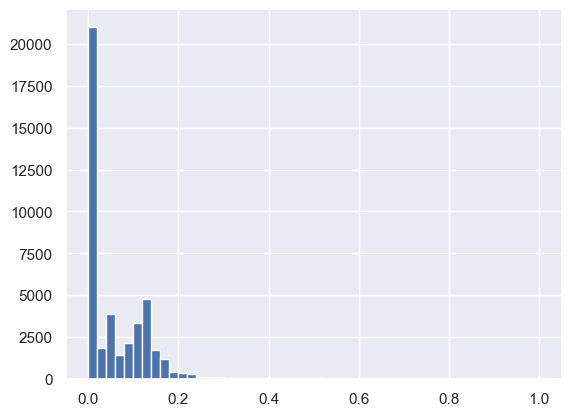

In [18]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

For the recovery_rate as lots of observations have a value of zero, we are going to take a 2-step approach:
1) Is recovery rate equal to 0 or greater than 0? -> Logistic regression

2) If recovery rate is greater than 0, how much exactly is it? -> Linear regression

In [19]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate']==0,0,1)
loan_data_defaults['recovery_rate_0_1']

1         1
8         1
9         1
12        1
14        1
         ..
466254    0
466256    0
466276    1
466277    0
466281    0
Name: recovery_rate_0_1, Length: 43236, dtype: int64

With this approach we are going to:

1) Apply the logistic regression to see if the recovery rate is greater than 0 or not. If it is, it will remain 0. If not, then we go further with step 2.

2) Using linear regression we will estimate the recovery rate for those recovery rates greater than 0.

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

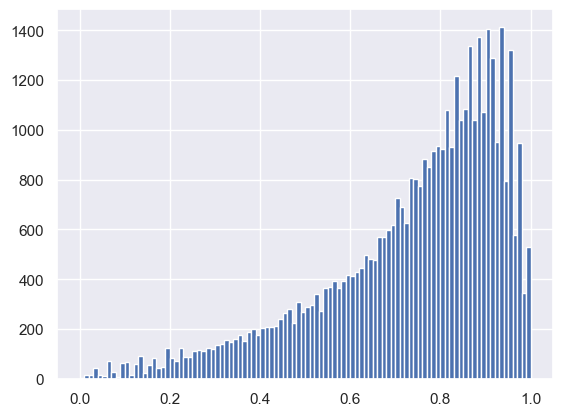

In [20]:
plt.hist(loan_data_defaults['ccf'], bins = 100)

As credit conversion factor distribution is much more homogeneous we will use a linear regression straightforward.

## LGD Model

### Splitting data

In [21]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad','recovery_rate','recovery_rate_0_1', 'ccf'], axis=1),loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

In [22]:
lgd_inputs_stage_1_train.shape

(34588, 206)

In [23]:
lgd_targets_stage_1_train.shape

(34588,)

In [24]:
lgd_inputs_stage_1_test.shape

(8648, 206)

In [25]:
lgd_targets_stage_1_test.shape

(8648,)

### Preparing the inputs

In [26]:
# Here we do not need to transform the numerical variables into categorical
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [27]:
with open("features_lgd", "wb") as fp:
    pickle.dump(features_all, fp)

In [28]:
# We only need reference categories for the categorical variables
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [29]:
with open("features_reference_cat_lgd", "wb") as fp:
    pickle.dump(features_reference_cat, fp)

In [30]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

In [31]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

In [32]:
lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

### Estimating the model

In [33]:
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [34]:
reg_lgd_st_1 = LogisticRegression_with_p_values(max_iter=300)
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

In [35]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [36]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.455908e-04,NaN
1,grade:A,-2.978260e-05,9.997219e-01
2,grade:B,-1.564048e-04,9.981904e-01
3,grade:C,-2.813972e-04,9.966212e-01
4,grade:D,2.644066e-05,9.996948e-01
5,grade:E,2.550163e-05,9.997330e-01
6,grade:F,1.463556e-04,9.986663e-01
7,home_ownership:MORTGAGE,-7.115361e-05,9.977766e-01
8,home_ownership:NONE,1.772376e-06,9.999982e-01
9,home_ownership:OTHER,5.971637e-07,9.999989e-01


In the case of the continuous variables, their coefficients reflect the change in log-odds that results from a unit change in the property the continuous variable measures.

### Testing the model

In [37]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

In [38]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [39]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [40]:
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 0])

In [41]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [42]:
y_hat_test_proba_lgd_stage_1

array([[0.42652525, 0.57347475],
       [0.37899685, 0.62100315],
       [0.51410414, 0.48589586],
       ...,
       [0.43090945, 0.56909055],
       [0.40974914, 0.59025086],
       [0.52526738, 0.47473262]])

In [43]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]

In [44]:
y_hat_test_proba_lgd_stage_1

array([0.57347475, 0.62100315, 0.48589586, ..., 0.56909055, 0.59025086,
       0.47473262])

In [45]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [46]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [47]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [48]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [49]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [50]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.573475
69814,1,0.621003
101396,0,0.485896
463268,1,0.531412
253729,0,0.417950


### Estimating the Аccuracy of the Мodel

In [51]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [52]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1387,2375
1,939,3947


In [53]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.160384,0.274630
1,0.108580,0.456406


As we then are going to estimate the LGD for values greater than 0, here it is more important to have a large proportion of correctly classified values that are greater than 0, than to have correctly classifed 0s.

This is because during the 2nd stage some of the values classified as > 1 may be estimated to be = 0, thus correcting the current misclassification.

In [54]:
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.6167900092506938

In [55]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5, 1.0, 'ROC curve')

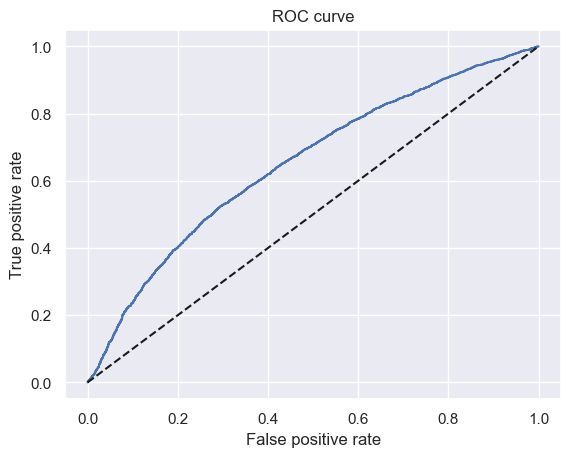

In [56]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [57]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6508142153595329

### Saving the Model

In [58]:
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb'))

### Stage 2 – Linear Regression

In [59]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [60]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'ccf'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [61]:
class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [62]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [63]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [64]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

/Users/fernandoemirgarade/opt/anaconda3/envs/ibk_env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [65]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [66]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


Here, as we are using a linear regression model, a coefficient shows the change in the dependdent variable thar is going to occur as a result of a unit change in the respective independent variable.

### Stage 2 – Linear Regression Evaluation

In [67]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [68]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [69]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [70]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [71]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [72]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [73]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


/var/folders/jz/r_v90_l50s1_y4gx6b256t2w0000gn/T/ipykernel_1063/483740359.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


<AxesSubplot:xlabel='recovery_rate', ylabel='Density'>

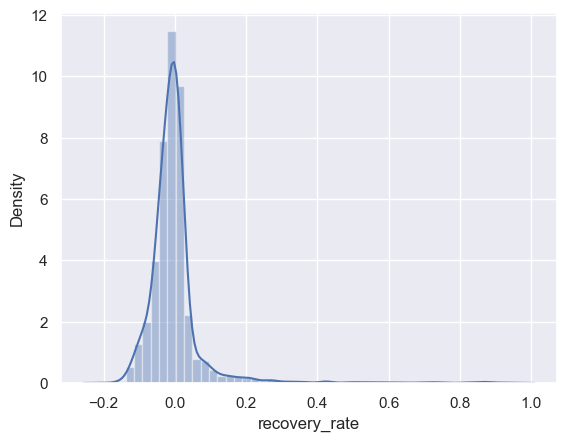

In [74]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

In [75]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

### Combining Stage 1 and Stage 2

In [76]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [77]:
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [78]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [79]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.076506
std,0.052010
min,-0.007634
25%,0.000000
50%,0.093511
75%,0.116846
max,0.236973


In [80]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [81]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.076508
std,0.052007
min,0.000000
25%,0.000000
50%,0.093511
75%,0.116846
max,0.236973


## EAD Model

### Estimation and Interpretation

In [82]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'ccf'], axis = 1), loan_data_defaults['ccf'], test_size = 0.2, random_state = 42)

In [83]:
ead_inputs_train.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

In [84]:
ead_inputs_train = ead_inputs_train[features_all]

In [85]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [86]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

/Users/fernandoemirgarade/opt/anaconda3/envs/ibk_env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [87]:
pickle.dump(reg_ead, open('reg_ead.sav', 'wb'))

In [121]:
feature_name = ead_inputs_train.columns.values

In [122]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,0.000000e+00
5,grade:E,-6.768713e-02,0.000000e+00
6,grade:F,-2.045907e-02,4.428795e-03
7,home_ownership:MORTGAGE,-6.343341e-03,2.632464e-03
8,home_ownership:NONE,-5.539064e-03,9.318931e-01
9,home_ownership:OTHER,-2.426052e-03,9.335820e-01


### Model Validation

In [123]:
ead_inputs_test = ead_inputs_test[features_all]

In [124]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [125]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [126]:
ead_targets_test_temp = ead_targets_test

In [127]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [128]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,ccf,0
ccf,1.000000,0.530654
0,0.530654,1.000000


/Users/fernando.garade/opt/anaconda3/envs/credit_risk/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ccf', ylabel='Density'>

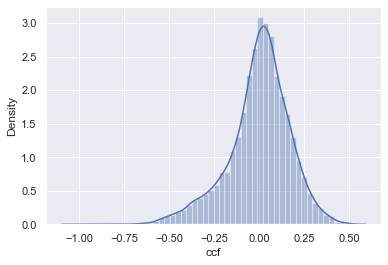

In [129]:
sns.distplot(ead_targets_test - y_hat_test_ead)

In [130]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [131]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [132]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


## Expected Loss

In [134]:
loan_data_preprocessed.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,0,0,0,0,0,0,0,1,0,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,0,0,0,0,0,0,0,1,0,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,0,0,0,0,0,0,0,1,0,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,0,0,0,0,0,0,0,1,0,1
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,0,0,0,0,0,0,0,1,0,1


In [135]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)

In [136]:
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [137]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [138]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [139]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [140]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [141]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [142]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [143]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [144]:
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.932112
std           0.058262
min           0.357914
25%           0.880516
50%           0.913731
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [145]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [146]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [147]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

In [148]:
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

In [149]:
loan_data_preprocessed.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


In [150]:
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')

In [151]:
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [152]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)

In [153]:
loan_data_inputs_pd.shape

(466285, 328)

In [154]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,0,1,0,0,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,1,0,0,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,1,0,0,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,1,0,0,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,0,0,0,0,0,1,0


In [155]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')

In [156]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,0,1,0,0,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,1,0,0,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,1,0,0,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,1,0,0,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,0,0,0,0,0,1,0


In [160]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length_int:0',
'emp_length_int:1',
'emp_length_int:2-4',
'emp_length_int:5-6',
'emp_length_int:7-9',
'emp_length_int:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86']

In [163]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length_int:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [162]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]

In [164]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [165]:
loan_data_inputs_pd_temp.shape

(466285, 84)

In [166]:
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

In [167]:
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

array([0.02956176, 0.09199724, 0.03734369, ..., 0.02677902, 0.04025101,
       0.04763147])

In [168]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

In [169]:
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.029562
206088    0.091997
136020    0.037344
412305    0.204221
36159     0.200136
Name: PD, dtype: float64

In [170]:
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.109322
std           0.070955
min           0.007300
25%           0.056072
50%           0.093511
75%           0.146572
max           0.645007
Name: PD, dtype: float64

In [171]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

In [172]:
loan_data_preprocessed_new.shape

(466285, 541)

In [173]:
loan_data_preprocessed_new.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,PD
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,1,0,0,0,0,0,0,0,0,0.164790
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,1,0,0,0,0,0,0,0,0,0.282677
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,1,0,0,0,0,0,0,1,0,0.231053
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,1,0,0,0,0,0,0,0,1,0.208820
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,1,0,0,0,0,0,0,0,1,0.129372


In [174]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [175]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean       1094.395071
std        1112.044558
min           9.533426
25%         357.684883
50%         714.516058
75%        1422.054806
max       12274.350811
Name: EL, dtype: float64

In [176]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.164790,0.913729,2949.608449,444.131269
1,2500,2500,0.282677,0.915482,1944.433378,503.191820
2,2400,2400,0.231053,0.919484,1579.934302,335.656597
3,10000,10000,0.208820,0.904924,6606.559612,1248.415757
4,3000,3000,0.129372,0.911453,2124.631667,250.529505


In [177]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [178]:
loan_data_preprocessed_new['EL'].sum()

510300005.8754629

In [179]:
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [180]:
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.076575
funded_amnt    0.076575
dtype: float64